In [109]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

# Centre Voltage Sweep

In [72]:
cen_v= pd.read_csv('./2019-06-29/phi0_daedalus_voltCenter_calib_2019-06-29_2.csv', comment="#")

In [74]:
cen_v[abs(cen_v.Yfield-0.1)<0.001]

,V,Xfield,Yfield,Zfield,elapsed_time
320,-1.9,0.000122,0.100828,-0.000297,165.569872


In [75]:
cen_vp = cen_v[cen_v.Yfield>0]
cen_vn = cen_v[cen_v.Yfield<0]

In [76]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vp_coeff, cen_vn_coeff])
print(cen_v_coeffs)

[[ 4.16168895e+03 -3.11844226e+03  5.47011535e+02 -2.84592899e+01
  -1.86123341e+01  8.26244300e-03]
 [ 4.15146313e+03  3.09829665e+03  5.35103810e+02  2.63857442e+01
  -1.86952107e+01 -1.33786176e-02]]


In [82]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

In [78]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)

In [79]:
cen_vp_fit(0.1)

-1.8607796688426999

<IPython.core.display.Javascript object>


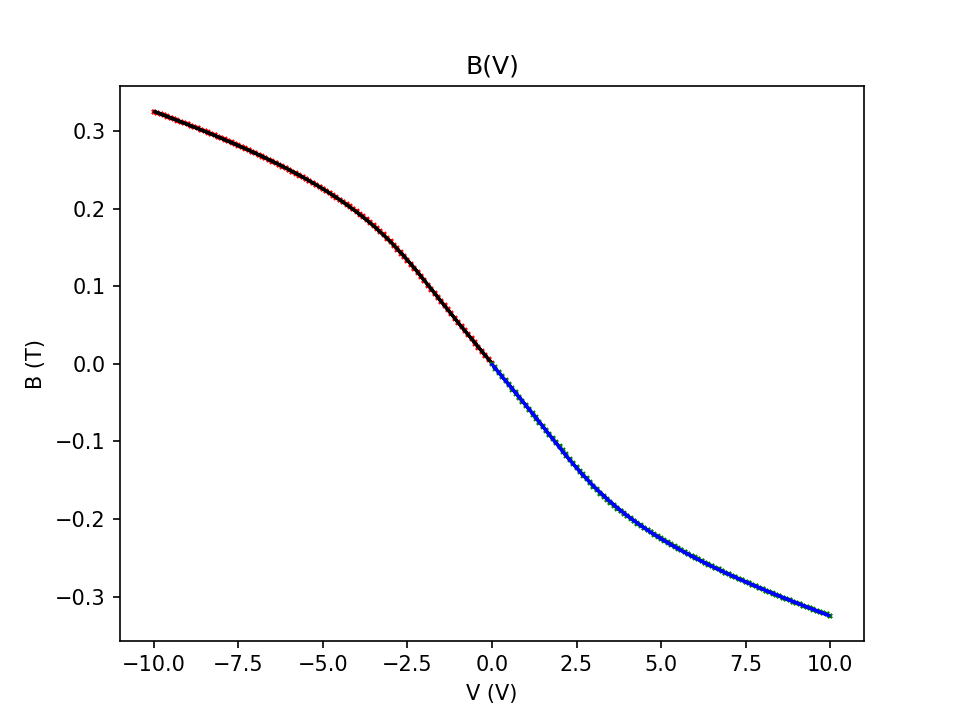

Text(0.5, 1.0, 'B(V)')

In [81]:
plt.figure(dpi=100)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 5 V

In [83]:
vp = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_6.csv', comment='#')
vn = pd.read_csv('./2019-06-29/test_daedalus_radialPolar_calib_A000.0_2019-06-29_7.csv', comment='#')

In [84]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [85]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [86]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -5.329e-14
Data variables:
    Xfield        (R) float64 -0.0001705
    Yfield        (R) float64 -0.2249
    Zfield        (R) float64 0.0007305
    theta         (R) float64 0.1861
    phi           (R) float64 -180.0
    elapsed_time  (R) float64 245.1
    Bmag          (R) float64 0.2249

In [87]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.4
Data variables:
    Xfield        (R) float64 -0.005288
    Yfield        (R) float64 -0.0002951
    Zfield        (R) float64 -0.1368
    theta         (R) float64 -89.88
    phi           (R) float64 -93.19
    elapsed_time  (R) float64 422.2
    Bmag          (R) float64 0.1368

<IPython.core.display.Javascript object>


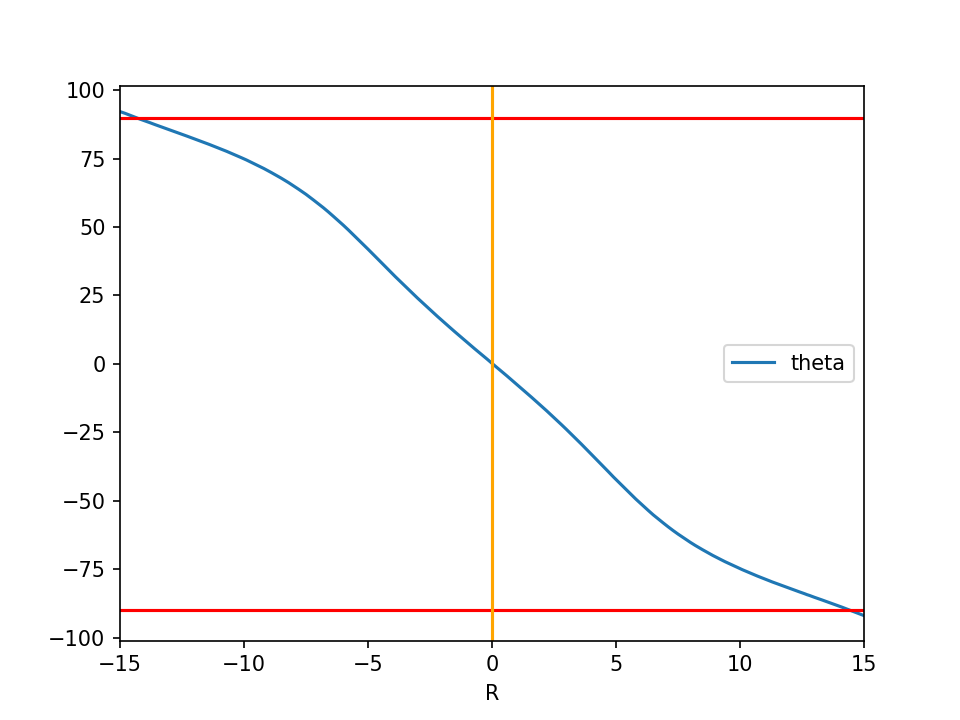

In [88]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

<IPython.core.display.Javascript object>


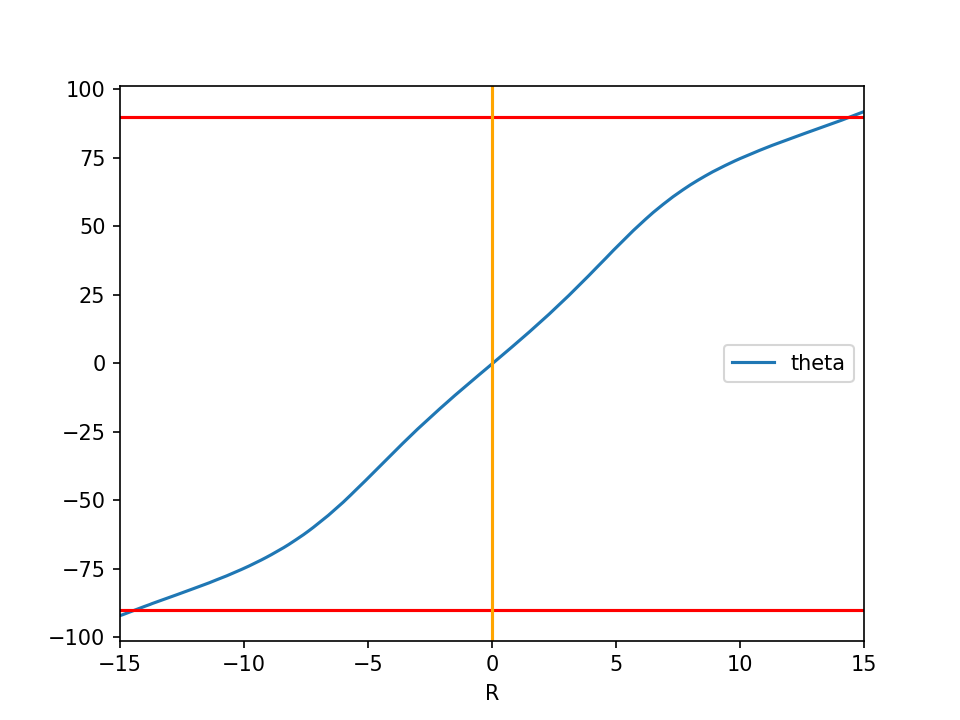

In [89]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [90]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

<IPython.core.display.Javascript object>


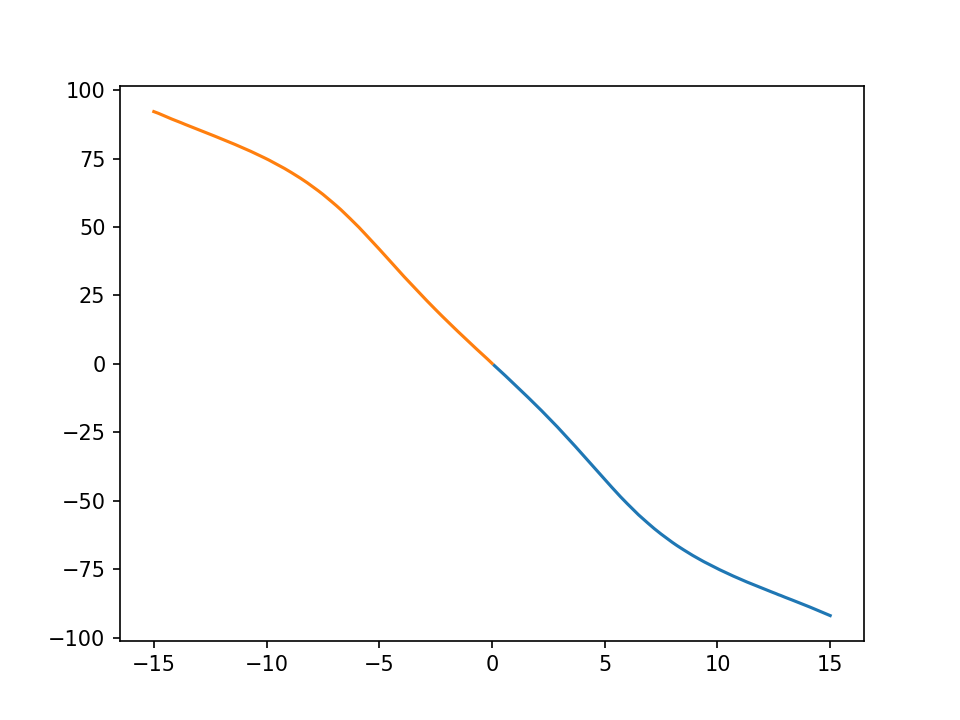

In [91]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

<IPython.core.display.Javascript object>


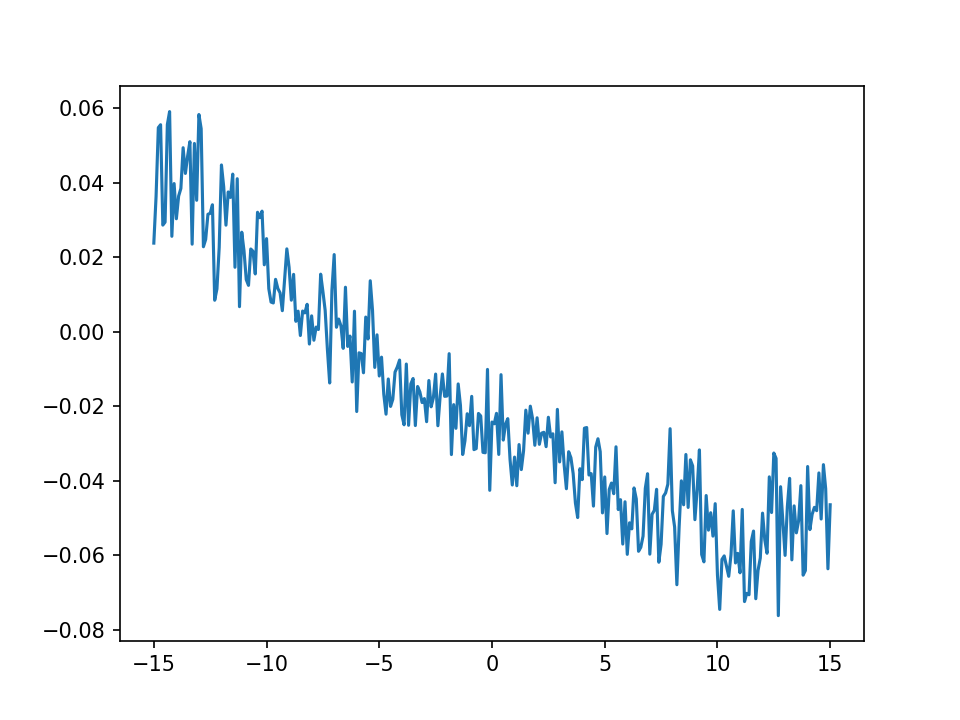

In [92]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Positive voltage R-theta relation

In [93]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 6)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 6)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.94073973e-10, -4.84340113e-08, -4.28111659e-06, -1.77582646e-04,
       -3.88923105e-03, -1.61647836e-01, -3.26154706e-02]), array([ 1.76091508e-10, -4.39138524e-08,  3.84152771e-06, -1.55574827e-04,
        3.30721453e-03, -1.56966347e-01,  7.21176746e-02]))


<IPython.core.display.Javascript object>


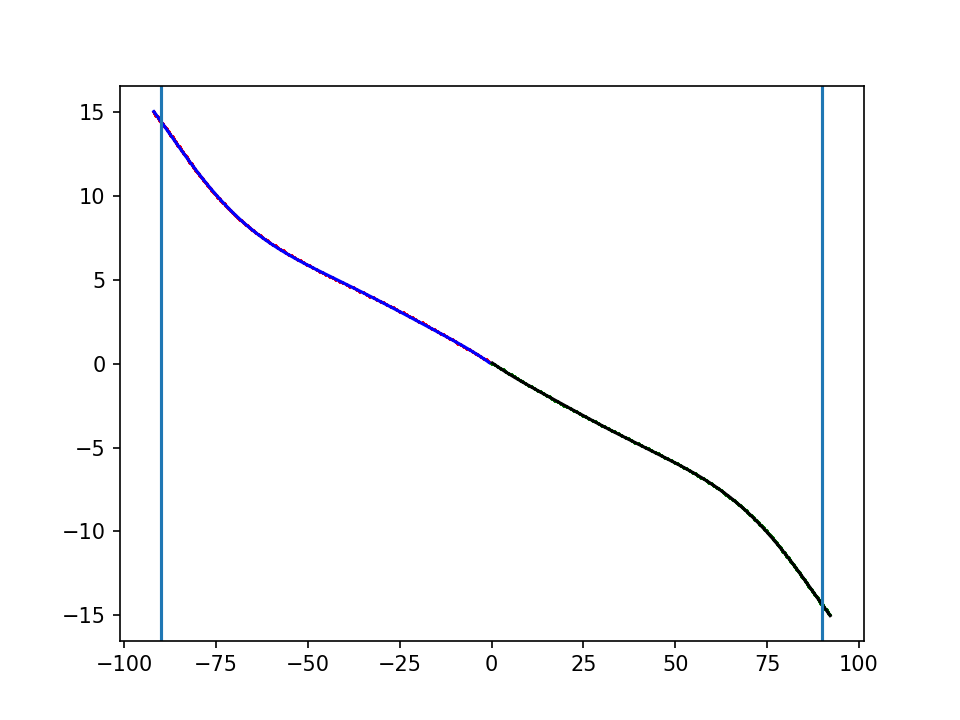

In [95]:
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [96]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

<IPython.core.display.Javascript object>


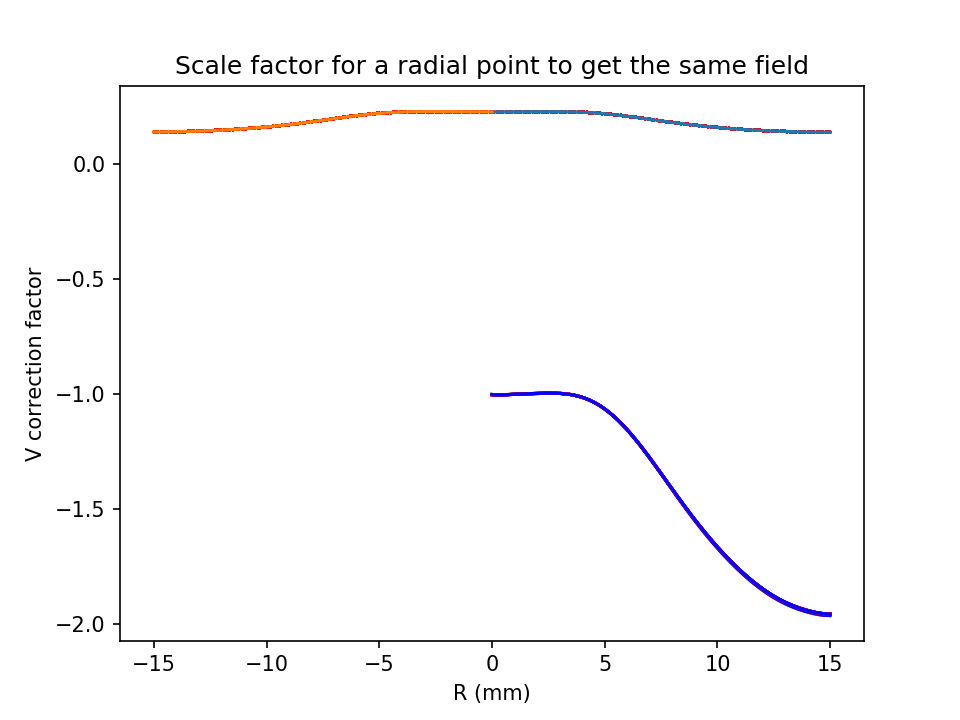

In [97]:
plt.figure(dpi=100)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
# plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
# plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
# plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

<IPython.core.display.Javascript object>


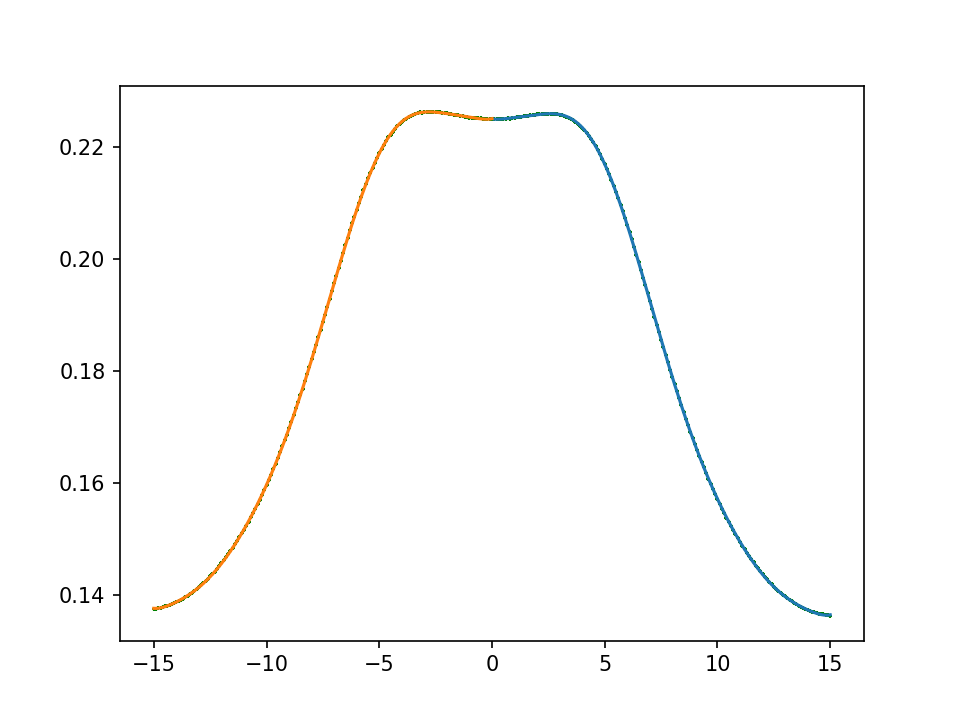

In [98]:
plt.figure(dpi=100)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### Voltage Correction function

In [99]:
V0 = 5.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)

In [100]:
vcent_vp_rp = V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = -V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = -V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [101]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [102]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[ 9.95526852e-10 -7.80010391e-08  2.57829438e-06 -4.64758149e-05
  4.92149115e-04 -3.07338951e-03  1.09765243e-02 -2.28181771e-02
  2.66841401e-02 -1.13851368e-02 -1.00319216e+00] 
 [ 9.01175695e-10  7.19660114e-08  2.42979003e-06  4.48560805e-05
  4.88146035e-04  3.14739305e-03  1.16575778e-02  2.48887424e-02
  2.92747549e-02  1.18690276e-02 -1.00324909e+00] 
 [ 9.84076387e-10 -7.73684915e-08  2.56629638e-06 -4.64192381e-05
  4.93179236e-04 -3.08912139e-03  1.10579994e-02 -2.29831581e-02
  2.66969438e-02 -1.11405179e-02 -1.00302190e+00] 
 [ 8.30367839e-10  6.71393005e-08  2.29329758e-06  4.27929712e-05
  4.70304282e-04  3.06062876e-03  1.14509191e-02  2.48034843e-02
  2.97559119e-02  1.23886880e-02 -1.00280868e+00]


In [103]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

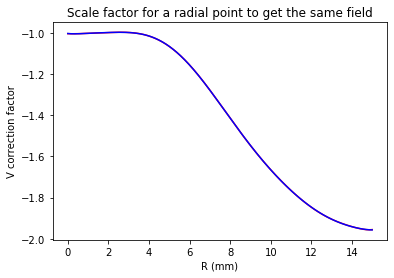

In [110]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

In [105]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1, 'Scale factor for a radial point to get the same field')

### 90 degrees

In [10]:
vp90 = pd.read_csv('./2019-06-28/5vp90_daedalus_radialPolar_calib_A090.0_2019-06-28_1.csv', comment='#')
vn90 = pd.read_csv('./2019-06-28/5vn90_daedalus_radialPolar_calib_A090.0_2019-06-28_1.csv', comment='#')

In [11]:
vp90 = vp90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp90 = vp90.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Xfield)*180/np.pi)
vp90 = vp90.assign(Bmag=lambda a: np.sqrt(a.Xfield**2 + a.Zfield**2))

vn90 = vn90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn90 = vn90.assign(theta=lambda a: np.arctan2(a.Zfield, a.Xfield)*180/np.pi)
vn90 = vn90.assign(Bmag=lambda a: np.sqrt(a.Xfield**2 + a.Zfield**2))

vp90_dv = {}
vn90_dv = {}
for c in vp90.columns[:]:
    vp90_dv[c] = (["R"],vp90[c])
    vn90_dv[c] = (["R"],vn90[c])
vp90_ds = xr.Dataset(vp90_dv)
vn90_ds = xr.Dataset(vn90_dv)

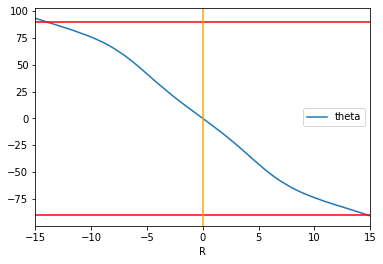

In [12]:
vp90.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

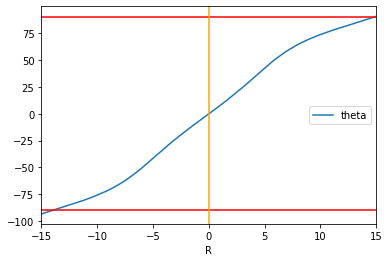

In [13]:
vn90.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [14]:
vp90_rp = vp90[vp90.R>0]
vp90_rn = vp90[vp90.R<0]
vn90_rp = vn90[vn90.R>0]
vn90_rn = vn90[vn90.R<0]

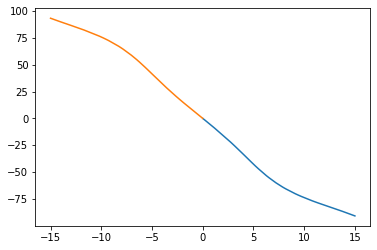

In [15]:
plt.plot(vp90_rp.R, vp90_rp.theta)
plt.plot(vp90_rn.R, vp90_rn.theta)

### Plot pos neg voltage discrepancy

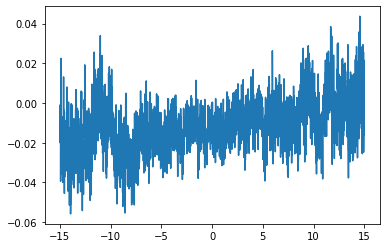

In [16]:
plt.plot(vp90.R, (vp90.theta+vn90.theta))

### Positive voltage R-theta relation

In [17]:
vp90_R_thetapos_coeff = np.polyfit(vp90_rp.theta, vp90_rp.R, 6)
vp90_R_thetaneg_coeff = np.polyfit(vp90_rn.theta, vp90_rn.R, 6)
vp90_R_thetapos = np.poly1d(vp90_R_thetapos_coeff)
vp90_R_thetaneg = np.poly1d(vp90_R_thetaneg_coeff)
R_theta90 = vp90_R_thetapos_coeff,vp90_R_thetaneg_coeff
print(R_theta90)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta90, delimiter=",")

(array([-2.20038918e-10, -5.33665460e-08, -4.58855053e-06, -1.85556524e-04,
       -3.94442279e-03, -1.60119097e-01, -3.96000666e-02]), array([ 1.50421396e-10, -3.85333747e-08,  3.44453525e-06, -1.41754881e-04,
        3.08195442e-03, -1.56619357e-01,  6.04727391e-02]))


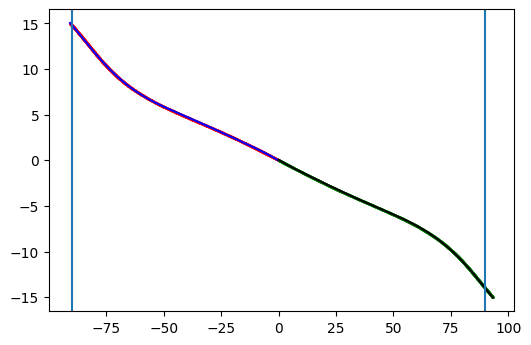

In [18]:
plt.figure(dpi=100)
plt.plot(vp90_rp.theta, vp90_rp.R, 'r+', markersize=2)
plt.plot(vp90_rp.theta, vp90_R_thetapos(vp90_rp.theta), 'b')
plt.plot(vp90_rn.theta, vp90_rn.R, 'g+', markersize=2)
plt.plot(vp90_rn.theta, vp90_R_thetaneg(vp90_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

### Difference between 0 and 90 fit

In [19]:
plt.plot(vp_rp.R, vp_rp.theta-vp90_rp.theta)

NameError: name 'vp_rp' is not defined

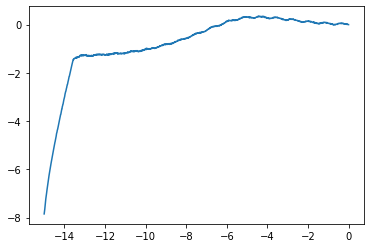

In [51]:
plt.plot(vp_rn.R, vp_rn.theta-vp90_rn.theta)

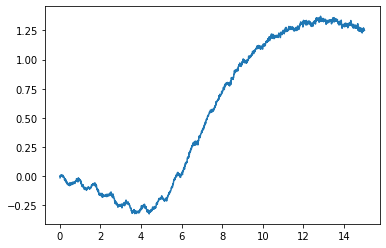

In [50]:
plt.plot(vn_rp.R, vn_rp.theta-vn90_rp.theta)

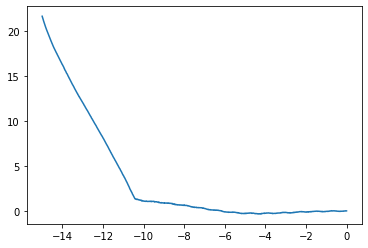

In [52]:
plt.plot(vn_rn.R, vn_rn.theta-vn90_rn.theta)

### Bmag

In [20]:
bmag_vp90_rp_coeff = np.polyfit(vp90[vp90.R>0].R, vp90[vp90.R>0].Bmag, 10)
bmag_vp90_rp = np.poly1d(bmag_vp90_rp_coeff)

bmag_vp90_rn_coeff = np.polyfit(vp90[vp90.R<0].R, vp90[vp90.R<0].Bmag, 10)
bmag_vp90_rn = np.poly1d(bmag_vp90_rn_coeff)

bmag_vn90_rp_coeff = np.polyfit(vn90[vn90.R>0].R, vn90[vn90.R>0].Bmag, 10)
bmag_vn90_rp = np.poly1d(bmag_vn90_rp_coeff)

bmag_vn90_rn_coeff = np.polyfit(vn90[vn90.R<0].R, vn90[vn90.R<0].Bmag, 10)
bmag_vn90_rn = np.poly1d(bmag_vn90_rn_coeff)

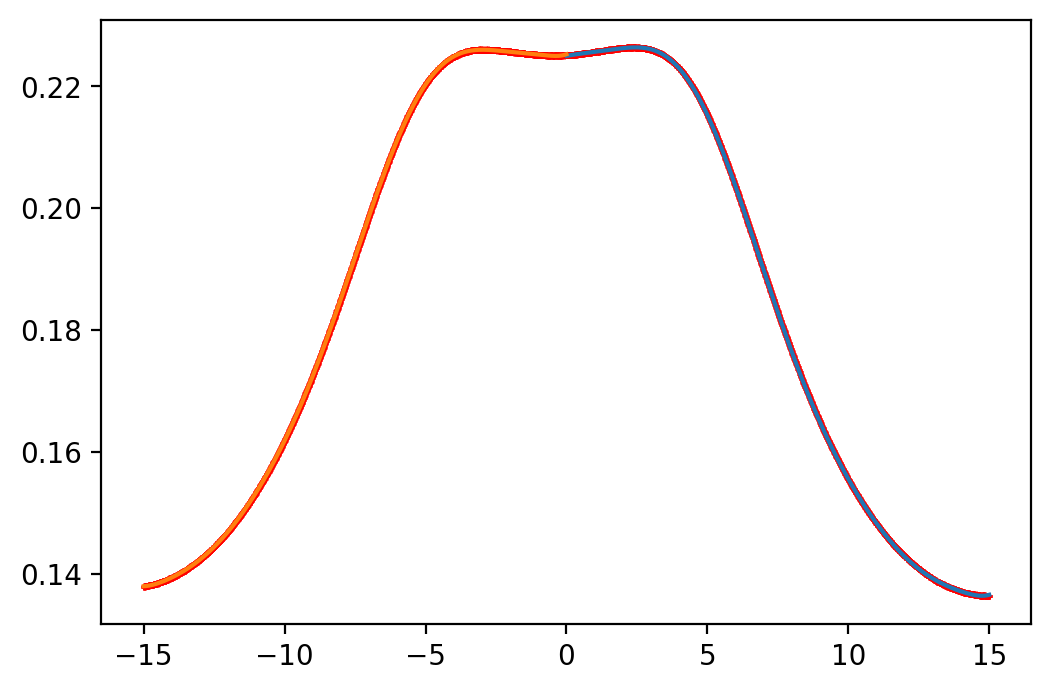

In [21]:
plt.figure(dpi=200)
plt.plot(vp90.R, vp90.Bmag, 'r+', markersize=2)
plt.plot(vp90[vp90.R>0].R, bmag_vp90_rp(vp90[vp90.R>0].R))
plt.plot(vp90[vp90.R<0].R, bmag_vp90_rn(vp90[vp90.R<0].R))

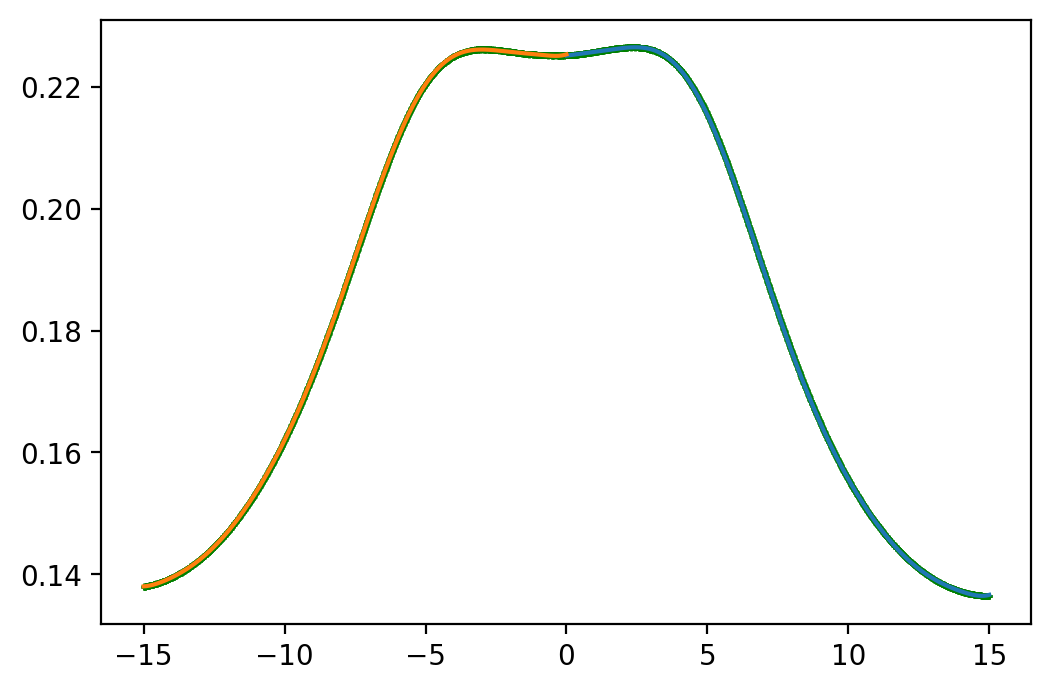

In [22]:
plt.figure(dpi=200)
plt.plot(vn90.R, vn90.Bmag, 'g+', markersize=2)
plt.plot(vn90[vn90.R>0].R, bmag_vn90_rp(vn90[vn90.R>0].R))
plt.plot(vn90[vn90.R<0].R, bmag_vn90_rn(vn90[vn90.R<0].R))

### Voltage Correction function

In [23]:
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)
vp0 = cen_vp_fit(bmag_vp90_rp(0.0))
vn0 = cen_vn_fit(-bmag_vn90_rp(0.0))

In [24]:
vcent_vp90_rp = vp0/cen_vp_fit(bmag_vp90_rp(Rpts_p))
vcent_vp90_rn = vp0/cen_vp_fit(bmag_vp90_rn(Rpts_n))
vcent_vn90_rp = vn0/cen_vn_fit(-bmag_vn90_rp(Rpts_p))
vcent_vn90_rn = vn0/cen_vn_fit(-bmag_vn90_rn(Rpts_n))

In [25]:
print(vcent_vp90_rp, vcent_vp90_rn, vcent_vn90_rp, vcent_vn90_rn)

[1.         0.99993803 0.99987612 ... 2.03154232 2.03132514 2.03109571] [2.00692938 2.00690115 2.00686566 ... 0.99830307 0.99817684 0.9980449 ] [1.         0.99996632 0.99993194 ... 1.87734975 1.87717194 1.87698404] [1.85800758 1.857975   1.85793688 ... 0.99888634 0.9987806  0.99867004]


In [26]:
n = 10
vcorr_vp90_rp_coeff = np.polyfit(Rpts_p, vcent_vp90_rp, n)
vcorr_vp90_rp = np.poly1d(vcorr_vp90_rp_coeff)
vcorr_vp90_rn_coeff = np.polyfit(Rpts_n, vcent_vp90_rn, n)
vcorr_vp90_rn = np.poly1d(vcorr_vp90_rn_coeff)
vcorr_vn90_rp_coeff = np.polyfit(Rpts_p, vcent_vn90_rp, n)
vcorr_vn90_rp = np.poly1d(vcorr_vn90_rp_coeff)
vcorr_vn90_rn_coeff = np.polyfit(Rpts_n, vcent_vn90_rn, n)
vcorr_vn90_rn = np.poly1d(vcorr_vn90_rn_coeff)

In [27]:
vcorr_vp90_rp_coeff

array([-1.17150734e-09,  8.97456206e-08, -2.89251614e-06,  5.06400015e-05,
       -5.17674838e-04,  3.08978370e-03, -1.03854020e-02,  2.02024078e-02,
       -2.14071345e-02,  4.96143713e-03,  9.98643852e-01])

In [28]:
print(vcorr_vp90_rp_coeff, '\n', vcorr_vp90_rn_coeff, '\n', vcorr_vn90_rp_coeff, '\n',vcorr_vn90_rn_coeff)

[-1.17150734e-09  8.97456206e-08 -2.89251614e-06  5.06400015e-05
 -5.17674838e-04  3.08978370e-03 -1.03854020e-02  2.02024078e-02
 -2.14071345e-02  4.96143713e-03  9.98643852e-01] 
 [-6.77649437e-10 -5.72949690e-08 -2.04573408e-06 -3.99005063e-05
 -4.58495732e-04 -3.12157984e-03 -1.22067333e-02 -2.73158142e-02
 -3.37350826e-02 -1.68267768e-02  9.97471019e-01] 
 [-1.06114123e-09  8.09886387e-08 -2.59938367e-06  4.52894527e-05
 -4.60397276e-04  2.73125865e-03 -9.14158306e-03  1.78872937e-02
 -1.94069823e-02  4.83206593e-03  9.99006060e-01] 
 [-6.57860884e-10 -5.47672978e-08 -1.92500493e-06 -3.69372752e-05
 -4.17024151e-04 -2.78275310e-03 -1.06206967e-02 -2.31276023e-02
 -2.80094797e-02 -1.37856584e-02  9.98238055e-01]


In [29]:
vcorr_coeffs = [vcorr_vp90_rp_coeff, vcorr_vn90_rp_coeff, vcorr_vp90_rn_coeff, vcorr_vn90_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

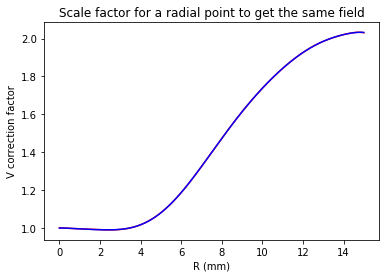

In [30]:
plt.plot(Rpts_p, vcent_vp90_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp90_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

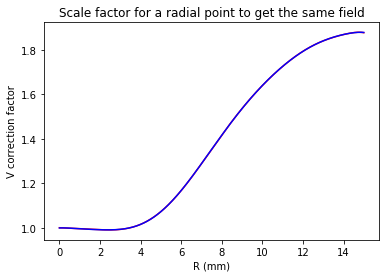

In [31]:
plt.plot(Rpts_p, vcent_vn90_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn90_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

In [60]:
np.arctan2(0.14, 0.006)*180/np.pi

87.54596832547293